# Orientation optimization

In [1]:
import torch
import matplotlib.pyplot as plt

from torchfem.io import import_mesh

In [2]:
E_xx = 100000
E_yy = 10000
G_xy = 5000
nu_xy = 0.1
nu_yx = E_yy / E_xx * nu_xy
C = torch.tensor(
    [
        [E_xx / (1 - nu_xy * nu_yx), nu_xy * E_yy / (1 - nu_xy * nu_yx), 0],
        [nu_yx * E_xx / (1 - nu_xy * nu_yx), E_yy / (1 - nu_xy * nu_yx), 0],
        [0, 0, G_xy],
    ]
)

# Rotation tensor
def R(phi):
    cos = torch.cos(phi)
    cos2 = cos**2
    sin = torch.sin(phi)
    sin2 = sin**2
    sincos = sin * cos
    return torch.stack(
        [
            torch.stack([cos2, sin2, 2 * sincos]),
            torch.stack([sin2, cos2, -2 * sincos]),
            torch.stack([-sincos, sincos, cos2 - sin2]),
        ],
    )

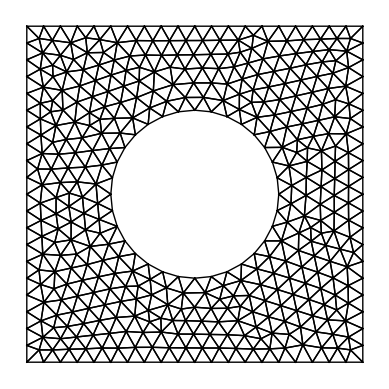

In [3]:
# Import mesh
plate = import_mesh("mesh.vtk", C=C)
plate.plot()

## Boundary conditions

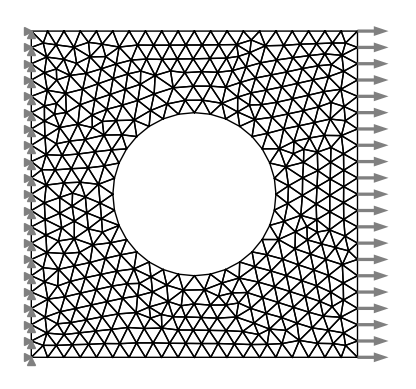

In [4]:
plate.constraints[plate.nodes[:, 0] == 0.0] = True
plate.forces[plate.nodes[:, 0] == 0.2] = 10.0
plate.forces[:, 1] = 0.0
plate.plot()

## Solve initial configuration

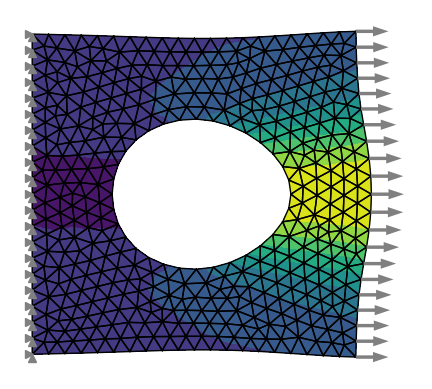

In [5]:
u, f = plate.solve()
plate.plot(u=u, node_property=u[:, 0])

# Optimization

## Target function is the strain energy

In [6]:
def target_function(phi):
    # Recompute stiffnesses due to changed orientations
    plate.C = torch.einsum("ij...,jk,lk...->...il", R(phi), C, R(phi))
    # Solve
    u, f = plate.solve()
    # Return compliance
    return torch.inner(u.ravel(), f.ravel())

## The optimization

In [7]:
phi = torch.zeros((len(plate.elements)), requires_grad=True)

optimizer = torch.optim.Adam([phi], lr=0.1)

energies = []

for i in range(100):
    optimizer.zero_grad()
    objective = target_function(phi)
    energies.append(objective.detach().item())
    objective.backward()
    optimizer.step()

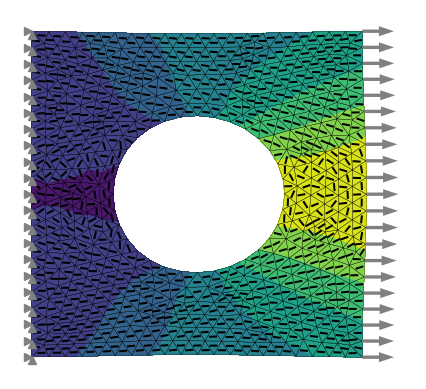

In [8]:
# Compute optimized displacements
u, f = plate.solve()

# Compute properties
pos = plate.nodes + u.detach()
centers = pos[plate.elements, :].mean(dim=1)
dir = torch.stack([torch.cos(phi), -torch.sin(phi), torch.zeros_like(phi)]).T.detach()

# Plot orientations
plate.plot(u=u, node_property=u[:, 0], linewidth=0.2)
plt.quiver(
    centers[:, 0],
    centers[:, 1],
    dir[:, 0],
    dir[:, 1],
    pivot="middle",
    headlength=0,
    headaxislength=0,
    headwidth=0,
    width=0.005,
)
plt.show()